<a href="https://colab.research.google.com/github/VardanKaushik/Compter-Vision-Mid-term/blob/main/Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing all necessary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

In [4]:
def plot_image(image_object,title=""):
    '''
    Funtion to plot the image
    '''
    plt.imshow(image_object)
    plt.title(title,fontweight='bold')
    plt.show()

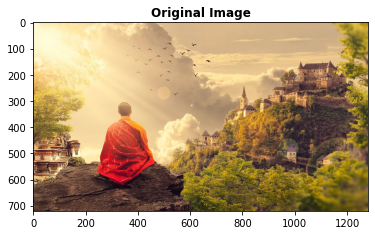

In [5]:
#Reading the image
img = mpimg.imread("image2.jpg")
#Plotting the image
plot_image(img,"Original Image")

In [198]:
print("Total number of pixels in  the image - "+str(img.size))
print("The shape of our image data - "+str(img.shape))

Total number of pixels in  the image - 2764800
The shape of our image data - (720, 1280, 3)


In [199]:
print("Total number of 16x16 pathces = "+str((720*1280)/(16*16)))

Total number of 16x16 pathces = 3600.0


In [180]:
#first converting the image into 2D by dividing it into rgb

img_array = np.array(img)
red = img_array[:,:,0]
green = img_array[:,:,1]
blue = img_array[:,:,2]

print(img_array.shape,red.shape,green.shape,blue.shape)

(720, 1280, 3) (720, 1280) (720, 1280) (720, 1280)


Question A

    Part 1 - Reconstruction of the image from applying PCA to 3600 patches of size 16x16

In [100]:
def pca(patch,k):
    '''
    Takes 16x16 patches and returns mean, eigenvalues and 
    eigenvectors corresponding to eigenvalues
    '''
    mean=np.mean(patch,axis=0)
    patch_normalized = (patch-mean)

    cov_matrix=np.cov(patch_normalized)

    eigenvalues,eigenvectors = np.linalg.eig(cov_matrix)

    #Gets the index of sorted (decreasing order) eigenvalues
    dec_index = np.argsort(eigenvalues)
    dec_index = dec_index[::-1]

    eigenvectors = eigenvectors[:,dec_index]
    eigenvalues = eigenvalues[dec_index]

    #Only takes the highest k eigenvalues and eigenvectors
    if(k<len(eigenvalues)):
        eigenvalues = eigenvalues[:k]
        eigenvectors = eigenvectors[:,:k]

    return mean,eigenvalues,eigenvectors
    

In [80]:
def reconstruction(image_arr,k,color):
    '''
    This function divides the image into patches
    Then, applies PCA to those patches
    Finally, reconstruct those patches and combine them into a single image
    '''
    img_recon=np.zeros((image_arr.shape[0],image_arr.shape[1]))

    for i in range(0,720,16):
        for j in range(0,1280,16):

            #Creating patches
            patch = image_arr[i:i+16,j:j+16]

            #Appliyint PCA to paches
            mean,eig_value,eig_vector = pca(patch,k)

            #Reconstructing patches
            rec_patch = mean + np.dot(eig_vector,np.dot(eig_vector.T,(patch-mean)))
            
            #Combining those patches to form the reconstructed image
            img_recon[i:i+16,j:j+16] = rec_patch
            img_recon = np.uint8(np.absolute(img_recon))
    
    return img_recon

In [81]:
#This part of the code calls the above function on red, green and blue
#for a range of k values(number of components to keep)
k_range=[1,10,100,150,200,500]
img_reconstructed_k=[]
for k_value in k_range:
    red_reconstructed = reconstruction(red,k_value,"Red")
    green_reconstructed = reconstruction(green,k_value,"Green")
    blue_reconstructed = reconstruction(blue,k_value,"Blue")
    img_reconstructed_k.append([(red_reconstructed,
                                 green_reconstructed,
                                 blue_reconstructed),k_value])   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


In [82]:
#This stores the reconstructed images corresponding to the value of K components
#which will be used in part 4, for quality assessment
image_reconstructed_k=[]
for [(red_reconstructed,green_reconstructed,blue_reconstructed),k_value] in img_reconstructed_k:
        image_reconstructed = np.dstack((red_reconstructed,green_reconstructed,blue_reconstructed))
        image_reconstructed_k.append([image_reconstructed,k_value])

In [83]:
#Conver tgb to color image and then store those images for different values of K

for [(red_reconstructed,green_reconstructed,blue_reconstructed),k_value] in img_reconstructed_k:
    if (k_value == 10) or (k_value == 100):
        image_reconstructed = np.dstack((blue_reconstructed,green_reconstructed,red_reconstructed))
        cv2.imwrite('/content/outputKValue{}.jpg'.format(k_value),image_reconstructed)

Question A

    Part 2 -> Showing and storing as 16x16 images the first 10 princial components

In [193]:
def plot_components(color,color_str):
    '''
    This function uses sklearn to calculate top 10 principal components 
    then, it reshapes those 10 eigenvectors with highest eigenvalue
    Finally, this show and stores the images for each rgb and return those rgb
    '''
     
    pca = PCA(n_components=10)
    pca.fit_transform(color)

    color_highest = pca.components_[:,0:256]
    color_pca = []
    for i in range(len(color_highest)):
        color_pca.append(color_highest[i].reshape(16,16))

    for i in range(len(color_pca)):
        plot_image(color_pca[i],"{} Highest Component for color = {}".format((i+1),color_str))
        cv2.imwrite('/content/color{}pca{}.jpg'.format(color_str,i+1),color_pca[i])

    return color_pca

In [ ]:
from sklearn.decomposition import PCA

#Original image - img, original red,green,blue - red,green,blue
#In this section, we take rgb and pass them to the function above
#then combine them all into a single colored image

colors=[(red,"Red"),
        (green,"Green"),
        (blue,"Blue")]
colors_pca=[]
for (color_image,color) in colors:
    colors_pca.append(plot_components(color_image,color))
    
print(len(colors_pca))
red_pca = colors_pca[0]
green_pca = colors_pca[1]
blue_pca = colors_pca[2]


for i in range(10):
    image_pca = np.dstack((blue_pca[i],green_pca[i],red_pca[i]))
    cv2.imwrite('/content/image_pca{}.jpg'.format(i+1),image_pca)



Question A

    Part 3 -> To select a better value of K

In [226]:
def plot_variance_vs_k(color,color_str):
    '''
    This function plots the explained variance ratio wrt the number of components
    taken for principal component analysis
    '''
    pca = PCA().fit(color)
    plt.plot(np.cumsum(pca.explained_variance_ratio_),label="Explained variance ratio")
    plt.title("Plot for color = {}".format(color_str),fontweight='bold')
    plt.ylabel("Cumulative Explained Variance",fontweight='bold')
    plt.xlabel('Number of components',fontweight='bold')
    ax = plt.gca()
    x_min,x_max = ax.get_xbound()
    y_min,y_max = ax.get_ybound()
    plt.plot([x_min,x_max],[0.95,0.95],linewidth=3,color='red',label="95% threshold")
    plt.legend()
    plt.plot([100,100],[y_min,y_max],linewidth=1,color='black',linestyle='dotted')
    plt.show()

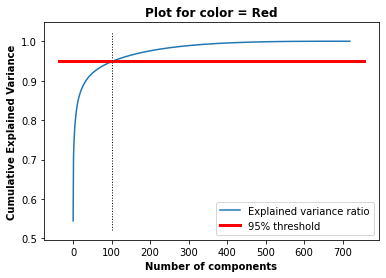

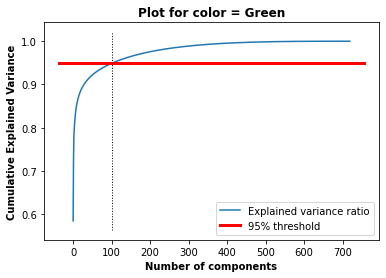

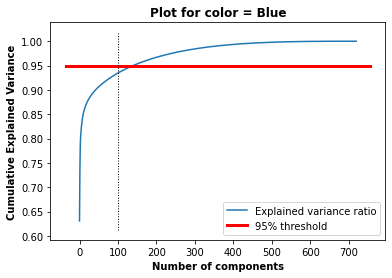

In [227]:
#This section calls the method above for red, green and blue
from sklearn.decomposition import PCA

colors=[(red,"Red"),
        (green,"Green"),
        (blue,"Blue")]

for (color,color_str) in colors:
    plot_variance_vs_k(color,color_str)



A

    4 - > Quality of the Image

In [88]:
def plot_quality_vs_k(similarities,k_range):
    '''
    This function plots how the quality of the image is changed with 
    changing value of K. This is done using the similarity between the 
    reconstructed image and the original image
    '''
    plt.ylabel("Quality of the reconsturcted Image",fontweight='bold')
    plt.xlabel("K Values",fontweight='bold')
    plt.title("Quality VS K value",fontweight='bold')
    plt.plot(k_range,similarities,color='navy',label="SSIM")
    plt.legend()
    plt.show()

In [89]:
def plot_image_comparision(original,reconstructed,similarity,k):
    '''
    This function plot the original image along with the reconstructed image 
    and also give the similarity score in the plot
    '''
    fig=plt.figure("Original VS Reconstructed")
    plt.suptitle("SSIM: %.2f for K = %.0f"%(similarity,k),fontweight='bold')
    #Plotting original image
    ax=fig.add_subplot(1,2,1)
    plt.imshow(original)
    plt.axis("off")
    #Plotting reconstructed image
    ax=fig.add_subplot(1,2,2)
    plt.imshow(reconstructed)
    plt.axis("off")
    plt.show()

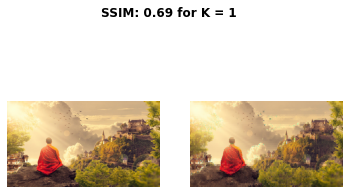

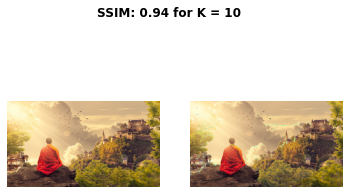

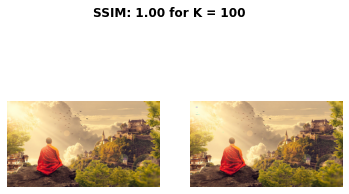

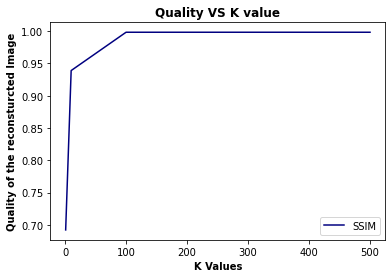

In [91]:
from skimage.metrics import structural_similarity as ssim

#Original Image is -> img
#Reconstructed images for k=10,100, my_value
#Reconstucted images stored in image_reconstructed_k

#numpy.nparray.flatten() -> the 1D copy of the nparrray
similarities = []

for [image_reconstructed,k_value] in image_reconstructed_k:
    similarity = ssim(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                      cv2.cvtColor(image_reconstructed, cv2.COLOR_BGR2GRAY))
    similarities.append(similarity)
    if (k_value==1) or (k_value==10) or (k_value==100):
        plot_image_comparision(img,image_reconstructed,similarity,k_value)

plot_quality_vs_k(similarities,k_range)